In [56]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import Transformer
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.pyplot as plt
import gstools as gs
import cartopy.io.shapereader as shpreader
import geopandas as gpd

In [57]:
df = pd.read_excel("dataframe_com_residuos.xlsx")
print(df.head())

   Unnamed: 0.1  Unnamed: 0       Data     3763_long       3763_lat  \
0             0           0 2018-06-20 -41240.983793  147938.005060   
1             1           1 2018-06-20 -66272.452636 -126138.602836   
2             2           2 2018-06-20 -43558.434663  107718.402059   
3             3           3 2018-06-20 -88100.749963 -104660.100318   
4             4           4 2018-06-20 -35388.726933  158867.677319   

   Estacao id               Estacao       pm10  pm10_weighted  \
0        1054          Anta-Espinho  13.681818      20.646031   
1        3093                 Arcos  36.491667      32.937641   
2        2017                Aveiro  27.125000      18.858698   
3        3075  Avenida da Liberdade  48.416667      32.890849   
4        1053               Avintes  27.200000      21.891247   

  Uso_solo_simplificado_500m  Urbanizado  Transporte  urban_pm10w  \
0                     Outros           0           0     0.000000   
1                 Urbanizado           1    

In [58]:
x = df["3763_long"]
y = df["3763_lat"]
residuals = df["residuals"].values


In [59]:
ds = xr.open_dataset("cams/PM10_daymean_2018.nc")  
cams_lons = ds.lon.values  
cams_lats = ds.lat.values 
grid_lon, grid_lat = np.meshgrid(cams_lons, cams_lats)

In [60]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3763", always_xy=True)
grid_x_flat, grid_y_flat = transformer.transform(grid_lon.ravel(), grid_lat.ravel())
grid_x_3763 = grid_x_flat.reshape(grid_lon.shape)
grid_y_3763 = grid_y_flat.reshape(grid_lat.shape)

In [61]:
OK = OrdinaryKriging(
    x,
    y,
    residuals,
    variogram_model='spherical',
    variogram_parameters={
        'sill': 20,
        'range': 20000.0,
        'nugget': 10.0
    },
    verbose=True,
    enable_plotting=False
)
residuals_interp, _ = OK.execute("points", grid_x_3763.ravel(), grid_y_3763.ravel())
residuals_interp = residuals_interp.reshape(grid_lon.shape)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 10.0
Full Sill: 20.0
Range: 20000.0
Nugget: 10.0 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [62]:
lasso_points = np.column_stack((x, y))
lasso_values = df["lasso_pm10"].values

target_points = np.column_stack((grid_x_3763.ravel(), grid_y_3763.ravel()))

lasso_interp = griddata(
    lasso_points,
    lasso_values,
    target_points,
    method="linear"
)

lasso_interp = lasso_interp.reshape(grid_x_3763.shape)
lasso_interp_filled = griddata(
    lasso_points,
    lasso_values,
    target_points,
    method="nearest"
).reshape(grid_x_3763.shape)



In [72]:
final_pm10_grid = lasso_interp + residuals_interp
#final_pm10_grid = residuals_interp
#final_pm10_grid = lasso_interp

In [64]:

# Download better resolution Natural Earth data
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

countries = gpd.read_file(shpfilename)

# Filter Iberia and project
iberia = countries[countries['NAME'].isin(['Portugal', 'Spain'])].to_crs("EPSG:3763")




Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


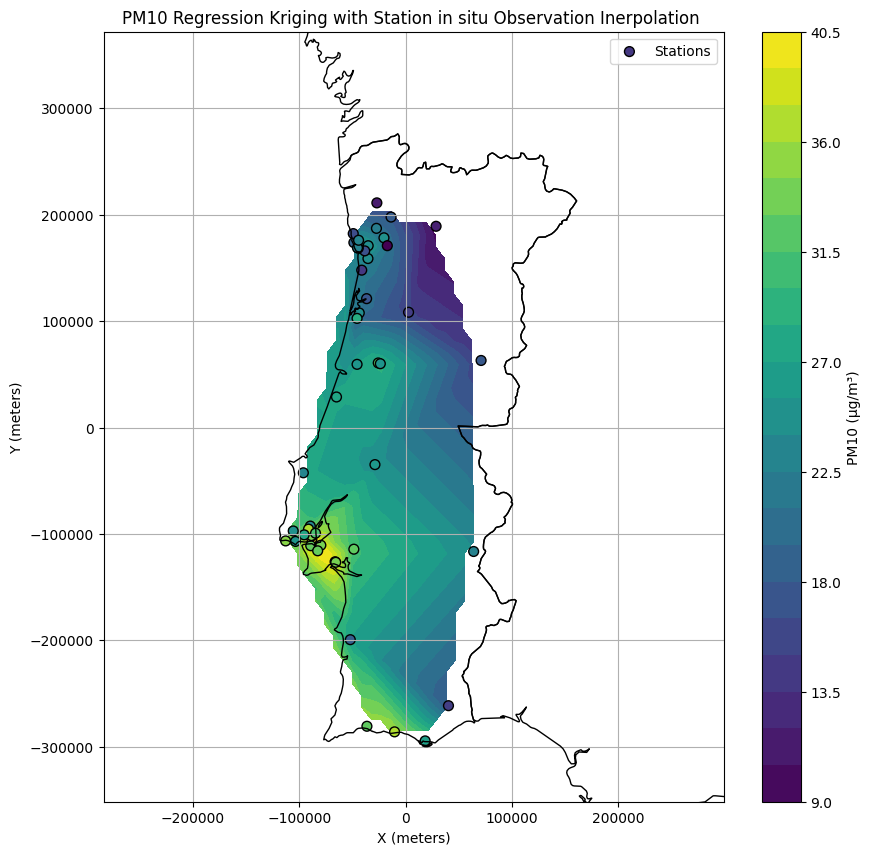

In [65]:
plt.figure(figsize=(10, 10))

contour = plt.contourf(grid_x_3763, grid_y_3763, final_pm10_grid, cmap="viridis", levels=25)
plt.colorbar(contour, label="PM10 (μg/m³)")

plt.scatter(df["3763_long"], df["3763_lat"], c=df["pm10"], cmap="viridis", edgecolor="k", s=50, label="Stations")

iberia.boundary.plot(ax=plt.gca(), color='black', linewidth=1)

plt.title("PM10 Regression Kriging with Station in situ Observation Inerpolation ")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.xlim(grid_x_3763.min(), grid_x_3763.max())
plt.ylim(grid_y_3763.min(), grid_y_3763.max())

plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


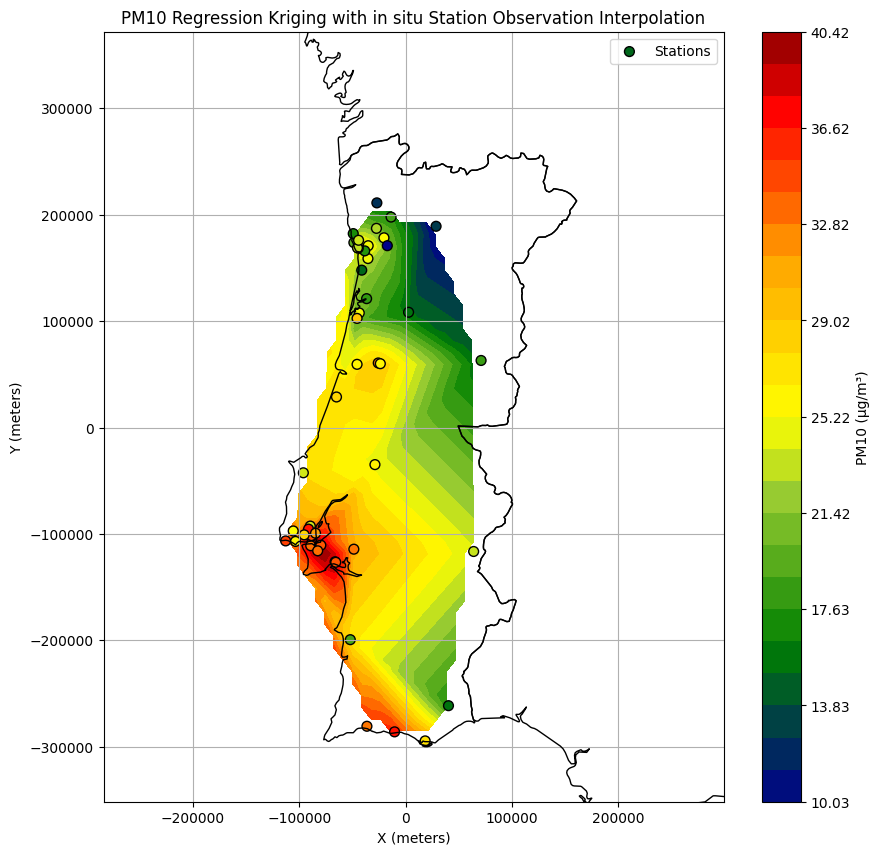

In [66]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define custom color transition (e.g., safe to hazardous)
colors = [
    (0, "darkblue"),    # very low
    (0.2, "green"),     # safe
    (0.4, "yellowgreen"),
    (0.5, "yellow"),    # 22.5 μg/m³ around here
    (0.7, "orange"),    # higher
    (0.9, "red"),       # dangerous
    (1.0, "darkred")    # very dangerous
]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_pm10", colors)

# Define levels with more focus around the 22.5 threshold
levels = np.linspace(np.nanmin(final_pm10_grid), np.nanmax(final_pm10_grid), 25)

# Plot
plt.figure(figsize=(10, 10))
contour = plt.contourf(grid_x_3763, grid_y_3763, final_pm10_grid, cmap=custom_cmap, levels=levels)
plt.colorbar(contour, label="PM10 (μg/m³)")

plt.scatter(df["3763_long"], df["3763_lat"], c=df["pm10"], cmap=custom_cmap, edgecolor="k", s=50, label="Stations")

iberia.boundary.plot(ax=plt.gca(), color='black', linewidth=1)

plt.title("PM10 Regression Kriging with in situ Station Observation Interpolation")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.xlim(grid_x_3763.min(), grid_x_3763.max())
plt.ylim(grid_y_3763.min(), grid_y_3763.max())
plt.show()


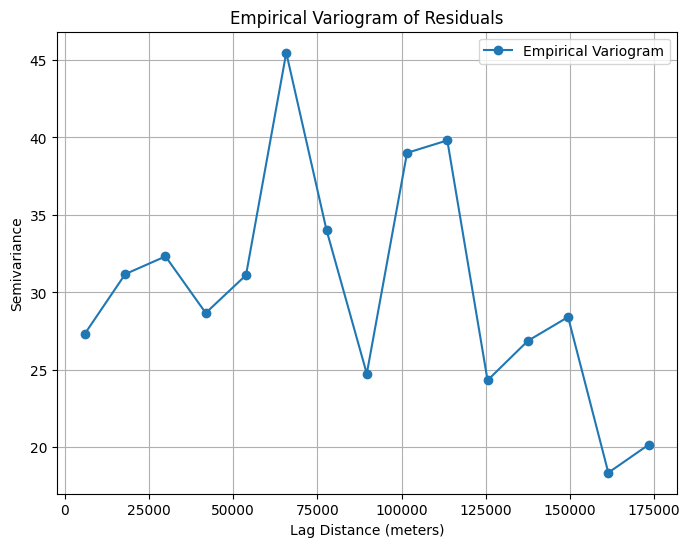

In [67]:
x = df['3763_long'].values
y = df['3763_lat'].values
residuals = df['residuals'].values

# Step 2: Define bin edges (correct format: tuple of (x, y))
bin_edges = gs.standard_bins((x, y), bin_no=15)

# Step 3: Compute empirical variogram
bin_center, gamma = gs.vario_estimate((x, y), residuals, bin_edges=bin_edges)

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.plot(bin_center, gamma, 'o-', label='Empirical Variogram')
plt.xlabel("Lag Distance (meters)")
plt.ylabel("Semivariance")
plt.title("Empirical Variogram of Residuals")
plt.grid(True)
plt.legend()
plt.show()


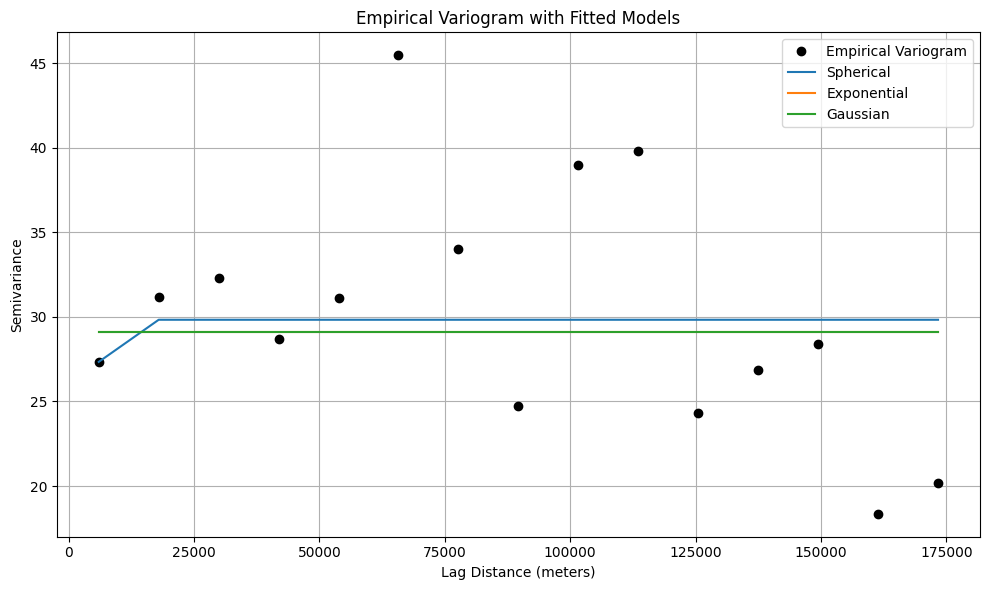

In [68]:
import gstools as gs
import matplotlib.pyplot as plt

# Define the empirical data again
coords = (x, y)  # tuple form
bin_edges = gs.standard_bins(coords, bin_no=15)
bin_center, gamma = gs.vario_estimate(coords, residuals, bin_edges=bin_edges)

# Choose model classes to try
model_classes = [gs.Spherical, gs.Exponential, gs.Gaussian]
model_names = ["Spherical", "Exponential", "Gaussian"]

# Plot empirical
plt.figure(figsize=(10, 6))
plt.plot(bin_center, gamma, 'ko', label='Empirical Variogram')

# Fit and plot each model
for model_class, name in zip(model_classes, model_names):
    model = model_class(dim=2)
    model.fit_variogram(bin_center, gamma)
    plt.plot(bin_center, model.variogram(bin_center), label=name)

plt.xlabel("Lag Distance (meters)")
plt.ylabel("Semivariance")
plt.title("Empirical Variogram with Fitted Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


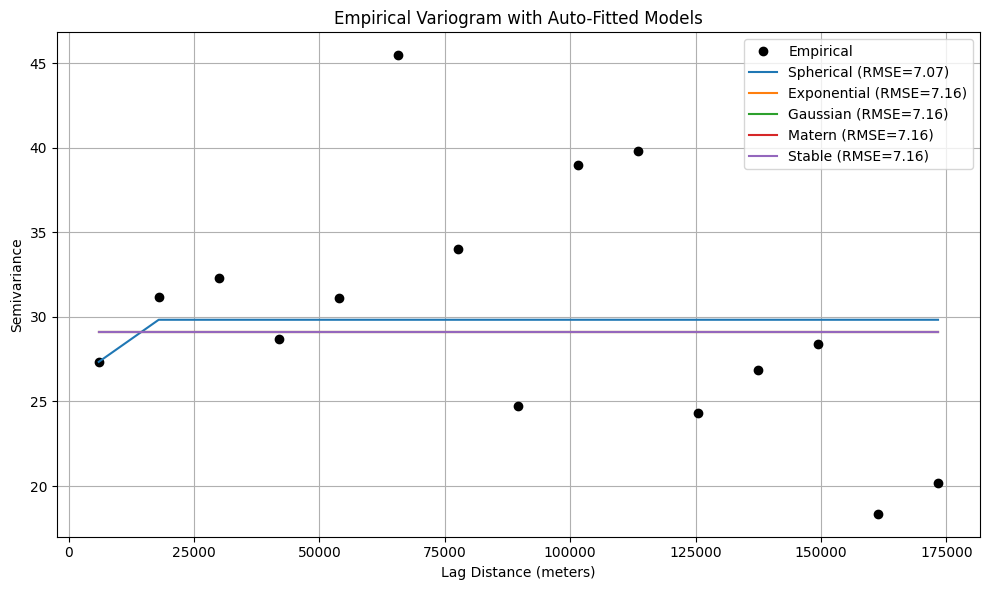

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.metrics import mean_squared_error

# Step 1: Get your empirical variogram
coords = (x, y)
bin_edges = gs.standard_bins(coords, bin_no=15)
bin_center, gamma = gs.vario_estimate(coords, residuals, bin_edges=bin_edges)

# Step 2: Define model candidates
model_classes = [gs.Spherical, gs.Exponential, gs.Gaussian, gs.Matern, gs.Stable]
model_names = ['Spherical', 'Exponential', 'Gaussian', 'Matern', 'Stable']

fitted_models = []
errors = []

# Step 3: Fit each model and compute RMSE
for model_class, name in zip(model_classes, model_names):
    model = model_class(dim=2)

    try:
        model.fit_variogram(bin_center, gamma)
        y_pred = model.variogram(bin_center)
        rmse = np.sqrt(mean_squared_error(gamma, y_pred))


        fitted_models.append((name, model, rmse))
        errors.append(rmse)
    except Exception as e:
        print(f"Model {name} failed: {e}")
        continue

# Step 4: Plot all models
plt.figure(figsize=(10, 6))
plt.plot(bin_center, gamma, 'ko', label='Empirical')

for name, model, rmse in fitted_models:
    plt.plot(bin_center, model.variogram(bin_center), label=f"{name} (RMSE={rmse:.2f})")

plt.xlabel("Lag Distance (meters)")
plt.ylabel("Semivariance")
plt.title("Empirical Variogram with Auto-Fitted Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5


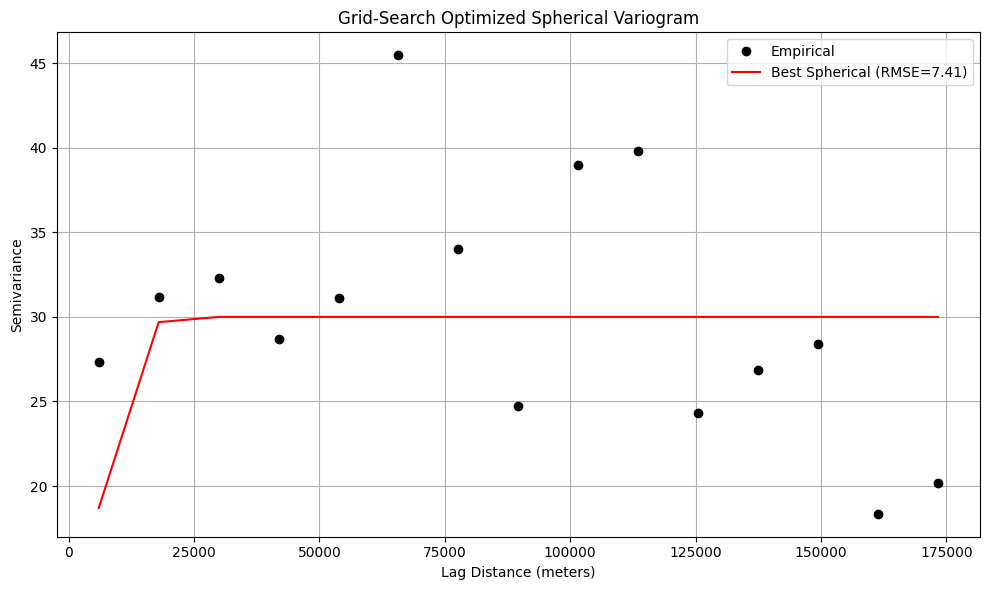

🏆 Best Spherical Model Parameters:
   Sill:   20.00
   Range:  20000.00
   Nugget: 10.00
   RMSE:   7.41


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.metrics import mean_squared_error
from itertools import product

# Empirical variogram setup
coords = (x, y)
bin_edges = gs.standard_bins(coords, bin_no=15)
bin_center, gamma = gs.vario_estimate(coords, residuals, bin_edges=bin_edges)

# Parameter search space
sills = np.linspace(10, 60, 6)         # test different sill values
ranges = np.linspace(20000, 150000, 7) # test different range values
nuggets = np.linspace(0, 15, 4)        # try different nugget values

best_model = None
best_rmse = np.inf
best_params = None

# Try all combinations
for sill, rng, nug in product(sills, ranges, nuggets):
    model = gs.Spherical(var=sill, len_scale=rng, nugget=nug, dim=2)
    try:
        y_pred = model.variogram(bin_center)
        rmse = np.sqrt(mean_squared_error(gamma, y_pred))
        if rmse < best_rmse:
            best_model = model
            best_rmse = rmse
            best_params = (sill, rng, nug)
    except Exception as e:
        continue

# Plot the best model
plt.figure(figsize=(10, 6))
plt.plot(bin_center, gamma, 'ko', label='Empirical')
plt.plot(bin_center, best_model.variogram(bin_center), 'r-', label=f'Best Spherical (RMSE={best_rmse:.2f})')

plt.xlabel("Lag Distance (meters)")
plt.ylabel("Semivariance")
plt.title("Grid-Search Optimized Spherical Variogram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final parameters
sill, rng, nug = best_params
print("🏆 Best Spherical Model Parameters:")
print(f"   Sill:   {sill:.2f}")
print(f"   Range:  {rng:.2f}")
print(f"   Nugget: {nug:.2f}")
print(f"   RMSE:   {best_rmse:.2f}")


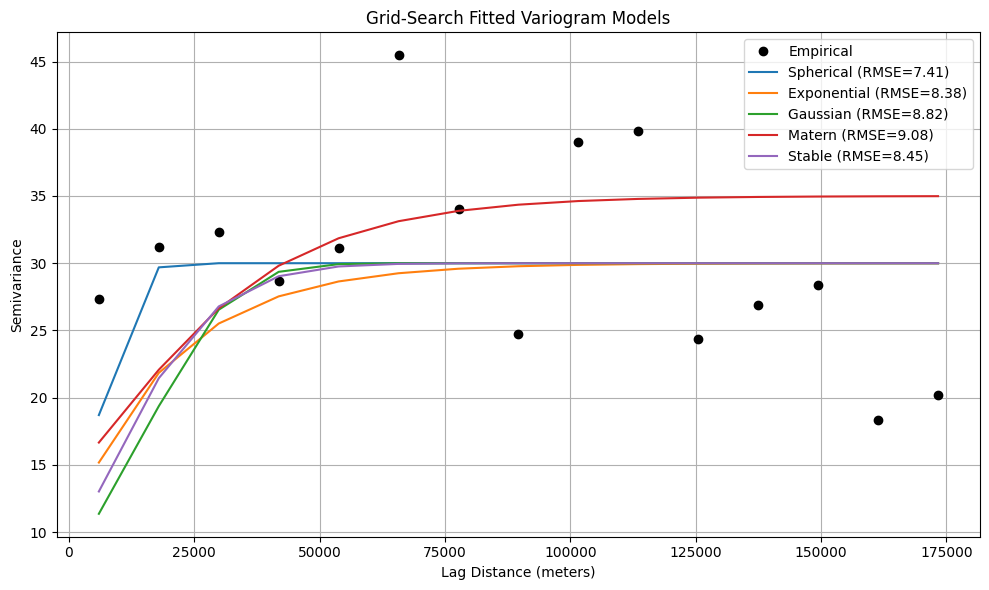

🏆 Best Overall Model:
   Model:  Spherical
   Sill:   20.00
   Range:  20000.00
   Nugget: 10.00
   RMSE:   7.41


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.metrics import mean_squared_error
from itertools import product

# 1. Prepare empirical variogram data
coords = (x, y)
bin_edges = gs.standard_bins(coords, bin_no=15)
bin_center, gamma = gs.vario_estimate(coords, residuals, bin_edges=bin_edges)

# 2. Define parameter search space
sills = np.linspace(10, 60, 6)
ranges = np.linspace(20000, 150000, 7)
nuggets = np.linspace(0, 15, 4)

# 3. Define models to test
model_classes = [gs.Spherical, gs.Exponential, gs.Gaussian, gs.Matern, gs.Stable]
model_names = ["Spherical", "Exponential", "Gaussian", "Matern", "Stable"]

results = []

# 4. Grid search for each model
for model_class, model_name in zip(model_classes, model_names):
    best_rmse = np.inf
    best_model = None
    best_params = None

    for sill, rng, nug in product(sills, ranges, nuggets):
        try:
            model = model_class(var=sill, len_scale=rng, nugget=nug, dim=2)
            y_pred = model.variogram(bin_center)
            rmse = np.sqrt(mean_squared_error(gamma, y_pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_params = (sill, rng, nug)
        except Exception as e:
            continue

    results.append({
        "name": model_name,
        "model": best_model,
        "rmse": best_rmse,
        "params": best_params
    })

# 5. Find overall best model
overall_best = min(results, key=lambda r: r["rmse"])

# 6. Plot all models
plt.figure(figsize=(10, 6))
plt.plot(bin_center, gamma, 'ko', label='Empirical')

for r in results:
    plt.plot(
        bin_center,
        r["model"].variogram(bin_center),
        label=f"{r['name']} (RMSE={r['rmse']:.2f})"
    )

plt.title("Grid-Search Fitted Variogram Models")
plt.xlabel("Lag Distance (meters)")
plt.ylabel("Semivariance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print best model
bp = overall_best["params"]
print("🏆 Best Overall Model:")
print(f"   Model:  {overall_best['name']}")
print(f"   Sill:   {bp[0]:.2f}")
print(f"   Range:  {bp[1]:.2f}")
print(f"   Nugget: {bp[2]:.2f}")
print(f"   RMSE:   {overall_best['rmse']:.2f}")
